# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from quantum_espresso_workflow import generate_structures
from quantum_espresso_workflow import get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.05)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    name="relax_get_dict",
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list, name="get_volumes")

In [11]:
get_energies_task = wg.add_task(get_list, name="get_energies")

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        name=f"get_dict_{i}",
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "nodes": [
    {
      "id": 0,
      "function": "quantum_espresso_workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 3,
      "function": "quantum_espresso_workflow.generate_structures"
    },
    {
      "id": 4,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 5,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 6,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 8,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 9,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 10,
      "function": "python_workflow_definition.shared.get_dic

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-04-12 15:54:47,296 INFO Started executing jobs locally
2025-04-12 15:54:47,541 INFO Starting job - get_bulk_structure (75604891-5f30-49fd-97cd-8f59b0a3895e)
2025-04-12 15:54:47,544 INFO Finished job - get_bulk_structure (75604891-5f30-49fd-97cd-8f59b0a3895e)
2025-04-12 15:54:47,545 INFO Starting job - get_dict (0743ebe6-3095-4e7d-a739-900669f7873e)
2025-04-12 15:54:47,547 INFO Finished job - get_dict (0743ebe6-3095-4e7d-a739-900669f7873e)
2025-04-12 15:54:47,548 INFO Starting job - calculate_qe (c2c29162-5e00-4b36-8a6c-f1d52bc1df9f)


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00174] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-12 15:55:40,677 INFO Finished job - calculate_qe (c2c29162-5e00-4b36-8a6c-f1d52bc1df9f)
2025-04-12 15:55:40,678 INFO Starting job - generate_structures (c0ed904d-e24e-4f9f-9c0a-d6b78d5e192a)
2025-04-12 15:55:40,682 INFO Finished job - generate_structures (c0ed904d-e24e-4f9f-9c0a-d6b78d5e192a)
2025-04-12 15:55:40,682 INFO Starting job - get_dict (7659e7c0-09e3-4179-9ab7-e6f465f77ebf)
2025-04-12 15:55:40,684 INFO Finished job - get_dict (7659e7c0-09e3-4179-9ab7-e6f465f77ebf)
2025-04-12 15:55:40,685 INFO Starting job - get_dict (2f9eceb5-885e-43c6-817c-2dce34de58a2)
2025-04-12 15:55:40,686 INFO Finished job - get_dict (2f9eceb5-885e-43c6-817c-2dce34de58a2)
2025-04-12 15:55:40,687 INFO Starting job - get_dict (04c12622-0c0e-4278-86fc-8e3c79bf3068)
2025-04-12 15:55:40,688 INFO Finished job - get_dict (04c12622-0c0e-4278-86fc-8e3c79bf3068)
2025-04-12 15:55:40,689 INFO Starting job - get_dict (dd1346c8-8f2a-417c-9347-c80eea106d43)
2025-04-12 15:55:40,690 INFO Finished job - get_dict (

[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00190] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-12 15:55:50,987 INFO Finished job - calculate_qe (55b6c69a-0494-48d1-b92f-aa77b8feb021)
2025-04-12 15:55:50,988 INFO Starting job - calculate_qe (ee153da1-ad96-48b8-bd1c-ac4dd4be109f)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00201] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-12 15:56:02,477 INFO Finished job - calculate_qe (ee153da1-ad96-48b8-bd1c-ac4dd4be109f)
2025-04-12 15:56:02,478 INFO Starting job - calculate_qe (97b1022f-d67a-4544-98bf-b5d4e11c19d4)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00212] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-12 15:56:14,246 INFO Finished job - calculate_qe (97b1022f-d67a-4544-98bf-b5d4e11c19d4)
2025-04-12 15:56:14,247 INFO Starting job - calculate_qe (d86d1bab-f0e3-4993-bcf1-16f85370ca7a)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00223] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-12 15:56:28,775 INFO Finished job - calculate_qe (d86d1bab-f0e3-4993-bcf1-16f85370ca7a)
2025-04-12 15:56:28,776 INFO Starting job - calculate_qe (d9caf96a-65e9-4ad0-9809-58ac600505d0)


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00234] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-12 15:56:42,906 INFO Finished job - calculate_qe (d9caf96a-65e9-4ad0-9809-58ac600505d0)
2025-04-12 15:56:42,907 INFO Starting job - get_list (3c1af8c6-b8c7-44e9-8bfd-2851a5b17f39)
2025-04-12 15:56:42,910 INFO Finished job - get_list (3c1af8c6-b8c7-44e9-8bfd-2851a5b17f39)
2025-04-12 15:56:42,911 INFO Starting job - get_list (30696726-b051-47d5-b74b-c435584b6d13)
2025-04-12 15:56:42,913 INFO Finished job - get_list (30696726-b051-47d5-b74b-c435584b6d13)
2025-04-12 15:56:42,914 INFO Starting job - plot_energy_volume_curve (01faca8d-e19f-44b1-bfd3-f0ddab5d3129)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-12 15:56:42,982 INFO Finished job - plot_energy_volume_curve (01faca8d-e19f-44b1-bfd3-f0ddab5d3129)
2025-04-12 15:56:42,983 INFO Finished executing jobs locally


{'75604891-5f30-49fd-97cd-8f59b0a3895e': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

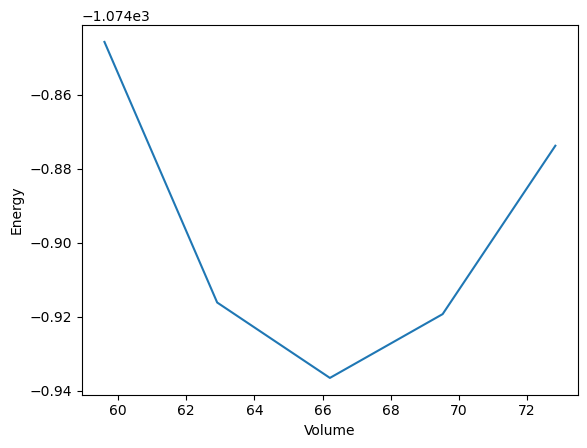

In [20]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [21]:
from pyiron_base import Project

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [23]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

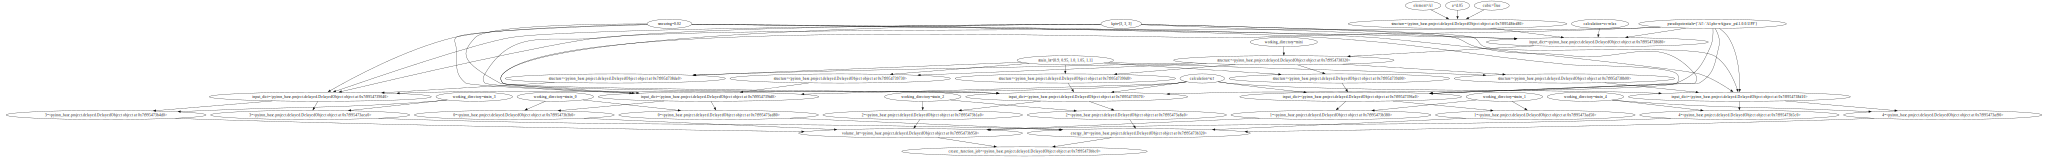

In [24]:
delayed_object_lst = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00271] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_2115236a4989acafb59b29e71f456689 was saved and received the ID: 4
The job get_dict_a23b0f53572e28c9f49dfc0f4fb8cf41 was saved and received the ID: 5
The job calculate_qe_3de99b6073748e7aba8e6f9f2d14cfa8 was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00286] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_51a8dc80fa977d486f449e7a3c30cceb was saved and received the ID: 7
The job calculate_qe_63f014496afacf57a51adaba4ad917fe was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00297] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_e9d53432a8af4527426b396e58131d27 was saved and received the ID: 9
The job calculate_qe_e0ce6ab4f9ee5d1390d723a597ebcb23 was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00309] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_8bf4fd88a782c3547094fd088f7aeda2 was saved and received the ID: 11
The job calculate_qe_8e4df17468034108e280d5af48dbe266 was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00320] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_3e4e8703ef1af4d93ce319f14544c770 was saved and received the ID: 13
The job calculate_qe_f480d034f43bea8218bde5fb00077415 was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-17n30fhy:00331] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_eacb691fa58e50c0936b26623a5e36f9 was saved and received the ID: 15
The job get_list_73e49e6d46edd9e606cb80a72981093b was saved and received the ID: 16
The job plot_energy_volume_curve_46660954bfed80bf61b9fcd22b7c7ae1 was saved and received the ID: 17


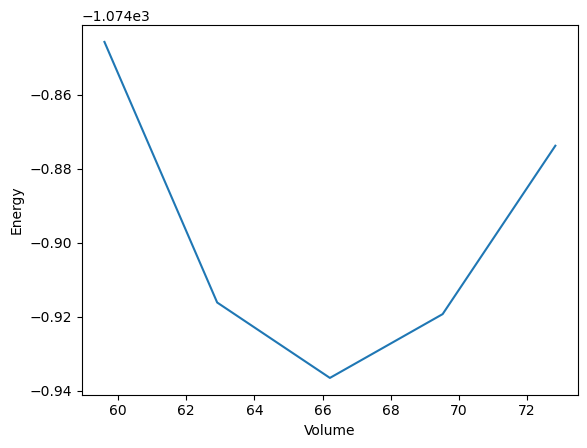

In [25]:
delayed_object_lst[-1].pull()